<a href="https://colab.research.google.com/github/HCelante/Machine_Learning/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importações

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import svm, datasets
%matplotlib inline

Importando Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Conhecendo o Dataset

1. PassengerId (numérico) – este atributo é simplesmente um identificador do passageiro na base de
dados. Provavelmente este atributo não deve ser usado como um atributo de entrada!
2. Pclass (numérico) – classe do bilhete. Este atributo pode ser visto como um proxy para o status
sócio-econômico do passageiro: 1=primeira classe (rico), 2=segunda classe (classe média) e 3=terceira
classe (pobre).
3. Name (string) – nome do passageiro.
4. Sex (categórico) – gênero do passageiro: male(masculino), female(feminino).
5. Age (numérico) – idade do passageiro (em anos).
6. SubSp (numérico) – número de irmãos + cônjuges a bordo.
7. Parch (numérico) – número de pais + filhos a bordo.
8. Ticket (string) – identificação do bilhete.
9. Fare (numérico) – preço pago pelo bilhete.
10. Cabin (string) – número da cabine que o passageiro ficou.
11. Embarked (categórico) – porto de embarque do passageiro: C=Cherbourg, Q=Queenstown,
S=Southampton.

In [ ]:
bkp = train
print(train.shape)
train

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Tratando valores nulos

In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

A quantidade de valores nulos para a coluna Cabine é muito alto se comparado ao número total de registros, então decidi retirá-lo

In [ ]:
train.drop('Cabin',
  axis='columns', inplace=True)

A coluna Idade e Embarcado não tem muitos valores nulos, então para relações que envolvem a idade, decidi dropar as linhas nulas

In [ ]:
age_drop = train.dropna()


In [ ]:
print(age_drop.shape)
age_drop.isnull().sum()


(712, 11)


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

A coluna de nomes e id dos passageiros decidi remover em ambos os dataframes, pois por se tratar de nomes não serve como característica comum para generalizar os sobreviventes.

In [ ]:
train  = train.drop(columns=['Name','PassengerId' ])
age_drop  = age_drop.drop(columns=['Name','PassengerId'])

Ja para relações que não envolvem a idade, decidi excluir a coluna inteira. No caso das coluna Embarcado, decidi excluir o registro. 

In [ ]:
print("\nAntes ---")
print(train.isnull().sum())
train  = train.drop(columns=['Age'])
train = train.dropna()
print("\nDepois ---")
print(train.isnull().sum())


Antes ---
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

Depois ---
Survived    0
Pclass      0
Sex         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64


Em resumo, separei os dados em 2 Datasets:

* age_drop = Registros nulos na coluna idade excluídos

* train = Sem a coluna idade

### Conversão dos atributos categóricos em atributos numéricos. 
A decisão para essa substituição foi arbitrária. Na ordem que eles aparecem, foi atribuído valores inteiros em ordem crescente. Os atributor não são ordinais

In [ ]:
def replacer(df):
  print(df.columns)
  for column in ['Pclass', 'Sex', 'Ticket', 'Embarked']:
    print("\n\n[+] Coluna: ", column, "\n [--] Valores unicos: ",df[column].unique())
    dict_column = {}

    cont = 0
    for uniq in df[column].unique():
      dict_column[uniq] = cont
      cont += 1
    print(" [--] Substituído: ", dict_column)
    df[column] = df[column].map(dict_column) 

In [ ]:
replacer(age_drop)
replacer(train)


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')


[+] Coluna:  Pclass 
 [--] Valores unicos:  [3 1 2]
 [--] Substituído:  {3: 0, 1: 1, 2: 2}


[+] Coluna:  Sex 
 [--] Valores unicos:  ['male' 'female']
 [--] Substituído:  {'male': 0, 'female': 1}


[+] Coluna:  Ticket 
 [--] Valores unicos:  ['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '17463'
 '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151' '347082'
 '350406' '248706' '382652' '345763' '239865' '248698' '330923' '113788'
 '347077' '19950' 'PC 17601' 'C.A. 24579' 'PC 17604' '113789' 'A./5. 2152'
 '345764' '2651' '7546' '11668' 'SC/Paris 2123' '330958' '349237'
 '3101295' 'A/4. 39886' 'PC 17572' '2926' '113509' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '36973' '347088' 'C.A. 29395' 'S.P. 3464'
 '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879' '2680' '1601' '348123'
 '248738' '364516' '345767' '345779' '113059' 'SO/C 14885' '3101278'

# 1. age_drop
Neste trecho exploramos o Dataset age_drop

In [ ]:
age_drop.shape

(712, 9)

In [ ]:
age_drop.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,0,0,22.0,1,0,0,7.2500,0
1,1,1,1,38.0,1,0,1,71.2833,1
2,1,0,1,26.0,0,0,2,7.9250,0
3,1,1,1,35.0,1,0,3,53.1000,0
4,0,0,0,35.0,0,0,4,8.0500,0


Separando X e y

In [ ]:
X = age_drop[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare','Embarked']]
y = age_drop[['Survived']]

# PCA

In [ ]:
from sklearn.decomposition import PCA

instanciando o PCA, indicando o interesse em manter apenas os 2 primeiros componentes principais.

In [ ]:
pca = PCA(n_components=2)  
pca.fit(X)

PCA(n_components=2)

Projetando os 8 atributos nos 2 componentes principais

In [ ]:
X_pca = pca.transform(X)  
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])
print("Instâncias priginais: %s\nInstâncias projetadas nos componentes principais: %s" % (str(X.shape), str(X_pca_df.shape)))

Instâncias priginais: (712, 8)
Instâncias projetadas nos componentes principais: (712, 2)


Plotando os dados projetados nos componentes principais

In [ ]:
y = np.array(y)
y = y.reshape(712*1)
y.shape

(712,)

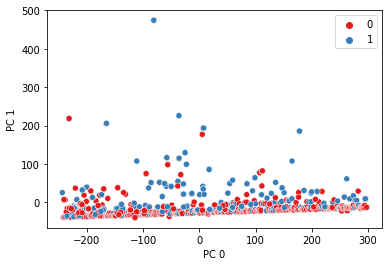

In [ ]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

Observando a escala dos atributos

In [ ]:
age_drop.groupby('Survived').mean().transpose()

Survived,0,1
Pclass,0.575472,0.993056
Sex,0.150943,0.677083
Age,30.626179,28.193299
SibSp,0.525943,0.496528
Parch,0.365566,0.531250
Ticket,243.266509,243.375000
Fare,22.965456,51.647672
Embarked,0.214623,0.329861


Verificando o peso dos componentes, fica claro que o ticket tem um peso bem diferente dos demais

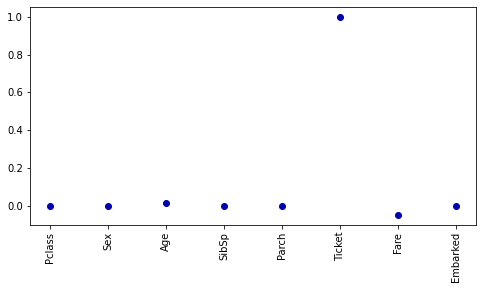

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(np.arange(len(X.columns)),pca.components_[0])
ax.set_xticks(np.arange(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=90)
plt.show()

In [ ]:
X

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,0,22.0,1,0,0,7.2500,0
1,1,1,38.0,1,0,1,71.2833,1
2,0,1,26.0,0,0,2,7.9250,0
3,1,1,35.0,1,0,3,53.1000,0
4,0,0,35.0,0,0,4,8.0500,0
...,...,...,...,...,...,...,...,...
885,0,1,39.0,0,5,15,29.1250,2
886,2,0,27.0,0,0,537,13.0000,0
887,1,1,19.0,0,0,538,30.0000,0
889,1,0,26.0,0,0,539,30.0000,1


Normalizando o dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()  # instancia o StandardScaler
ss.fit(X)              # estima a média e o desvio-padrão de todos atributos
X_ss = ss.transform(X) # realiza a normalização z-score nos atributos

In [ ]:
#calcula o PCA com os atributos normalizados
pca_ss = PCA(n_components=2)
pca_ss.fit(X_ss)
X_ss_pca = pca_ss.transform(X_ss)
X_ss_pca_df = pd.DataFrame(X_ss_pca, columns=['PC 0', 'PC 1'])

Os pesos dos atributos em ambos componentes principais estão distribuídos. Isto nos dá a confiança que o PCA não está enviesado em nenhum atributo específico. Como estes componentes foram estimados com dados em mesma escala, sabemos que não há risco de enviesamento por conta de diferenças em escala.

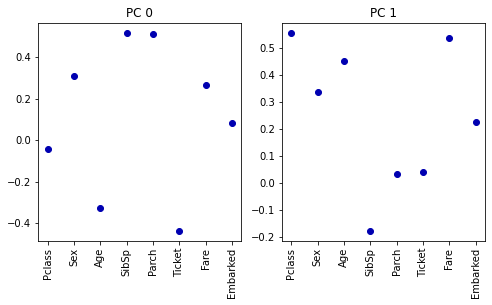

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
for idx, pc in enumerate(pca_ss.components_):
    ax[idx].scatter(np.arange(len(X.columns)), pc)
    ax[idx].set_xticks(np.arange(len(X.columns)))
    ax[idx].set_xticklabels(X.columns, rotation=90)
    ax[idx].set_title('PC %d' % (idx))
plt.show()

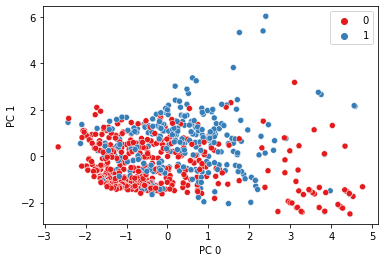

In [ ]:
sns.scatterplot(data=X_ss_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

Para verificar o quanto que a projeção do PCA representa os dados, decidi avaliar taxa de variância explicada pelos componentes principais usados na projeção.

In [ ]:
pca_ss.explained_variance_ratio_, sum(pca_ss.explained_variance_ratio_)

(array([0.25106198, 0.17500655]), 0.4260685375731744)

Os 2 primeiros componentes principais conseguem capturar 42% da variação dos dados. 

# Validação Cruzada

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val

In [ ]:
#a validação cruzada será realizada em 10 vias.
k_vias = 10
X = np.array(X)
#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X[idx_treino]
    y_treino = y[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X[idx_teste]
    y_teste = y[idx_teste]
    
    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #escolher o k com o melhor resultado no conjunto de validação e treinar o KNN com o melhor k.
    knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))

min: 0.72, max: 0.89, avg +- std: 0.80+-0.05


Esse resultado nos diz que podemos esperar que nosso classificador acerte entre 77% e 85% dos casos no mundo real

In [ ]:
from sklearn.model_selection import GridSearchCV #busca exaustiva para otimização de hiperparâmetro por validação cruzada

k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 10 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X[idx_treino]
    y_treino = y[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X[idx_teste]
    y_teste = y[idx_teste]
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {'n_neighbors' : range(1,30,2)}
    #instanciar um KNN com parametros padrão
    knn = KNeighborsClassifier()
    #instanciar um GridSearchCV com k2 vias.
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2))
    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    knn.fit(X_treino, y_treino)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))

min: 0.72, max: 0.86, avg +- std: 0.79+-0.04


# KNN x SVM
## 1. KNN

In [ ]:
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from joblib import Parallel, delayed
def selecionar_melhor_k_knn(ks, X_treino, X_val, y_treino, y_val):
    
    def treinar_knn(k, X_treino, X_val, y_treino, y_val):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        return accuracy_score(y_val, pred)
        
    acuracias_val = Parallel(n_jobs=4)(delayed(treinar_knn)(k, X_treino, X_val, y_treino, y_val) for k in ks)       
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val

def do_cv_knn(X, y, cv_splits, ks):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    classification_reports = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        knn, _, _ = selecionar_melhor_k_knn(ks, X_treino, X_val, y_treino, y_val)
        pred = knn.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        pgb.update(1)
        
    pgb.close()
    
    return acuracias
    
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

Avaliando o desempenho do KNN nesta base de dados usando validação cruzada. 

In [ ]:
accs_knn = do_cv_knn(X, y, 10, range(1, 20, 2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
imprimir_estatisticas(accs_knn)

Resultados: 0.80 +- 0.04, min: 0.72, max: 0.89


## SVM

In [ ]:
from sklearn.svm import SVC
import itertools
#Cs e gammas são listas com os valores a serem avaliados para os respectivos parâmetros.
def selecionar_melhor_svm(Cs, gammas, X_treino : np.ndarray, X_val : np.ndarray, 
                          y_treino : np.ndarray, y_val : np.ndarray, n_jobs=4):
    
    def treinar_svm(C, gamma, X_treino, X_val, y_treino, y_val):
        svm = SVC(C=C, gamma=gamma)
        svm.fit(X_treino, y_treino)
        pred = svm.predict(X_val)
        return accuracy_score(y_val, pred)
    
    #gera todas as combinações de parametros C e gamma, de acordo com as listas de valores recebidas por parametro.
    #Na prática faz o produto cartesiano entre Cs e gammas.
    combinacoes_parametros = list(itertools.product(Cs, gammas))
    
    #Treinar modelos com todas as combinações de C e gamma
    acuracias_val = Parallel(n_jobs=n_jobs)(delayed(treinar_svm)
                                       (c, g, X_treino, X_val, y_treino, y_val) for c, g in combinacoes_parametros)       
    
    melhor_val = max(acuracias_val)
    #Encontrar a combinação que levou ao melhor resultado no conjunto de validação
    melhor_comb = combinacoes_parametros[np.argmax(acuracias_val)]   
    melhor_c = melhor_comb[0]
    melhor_gamma = melhor_comb[1]
    
    #Treinar uma SVM com todos os dados de treino e validação usando a melhor combinação de C e gamma.
    svm = SVC(C=melhor_c, gamma=melhor_gamma)
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_comb, melhor_val

#Implementa a validação cruzada para avaliar o desempenho da SVM na base de dados com as instâncias X e as saídas y.
#cv_splits indica o número de partições que devem ser criadas.
#Cs é a lista com os valores C que devem ser avaliados na busca exaustiva de parametros para a SVM.
#gammas s é a lista com os valores gamma que devem ser avaliados na busca exaustiva de parametros para a SVM.
def do_cv_svm(X, y, cv_splits, Cs=[1], gammas=['scale']):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        svm, _, _ = selecionar_melhor_svm(Cs, gammas, X_treino, X_val, y_treino, y_val)
        pred = svm.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        pgb.update(1)
        
    pgb.close()
    
    return acuracias

In [ ]:
accs_svm = do_cv_svm(X, y, 10, Cs=[1, 10, 100, 1000], gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4])

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
imprimir_estatisticas(accs_knn)

Resultados: 0.80 +- 0.04, min: 0.72, max: 0.89


In [ ]:
imprimir_estatisticas(accs_svm)

Resultados: 0.82 +- 0.06, min: 0.70, max: 0.92


A acurácia do SVM parece ter sido ligeiramente superior, porém o desvio padrão está razoavelmente alto.

# Teste de Hipótese Nula pelo Teste t de Student

In [ ]:
from scipy.stats import ttest_ind_from_stats

In [ ]:
#Primeiramente calculamos a média e o desvio padrão dos resultados
media_knn, std_knn, _, _ = calcular_estatisticas(accs_knn)
media_svm, std_svm, _, _ = calcular_estatisticas(accs_svm)

#calcular o pvalor usando o teste t de Student para duas amostras independentes
_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(accs_knn), media_svm, std_svm, len(accs_svm))

In [ ]:
pvalor

0.5822453534864342

In [ ]:
pvalor<=0.05

False

Como o valor é maior que 0.05, não é possível rejeitar a hipótese nula.
 Em outras palavras, não é possível afirmar que a SVM teve desempenho diferente do KNN nos testes que fizemos com esta base de dados.

In [ ]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [ ]:
rejeitar_hip_nula(media_knn, std_knn, len(accs_knn), media_svm, std_svm, len(accs_svm))

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
pred = knn.predict(X_test)
accuracy_score(y_test, pred)

0.6083916083916084

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


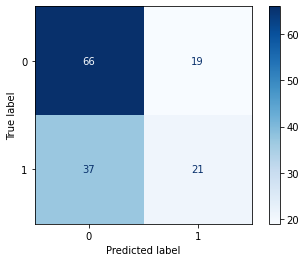

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues')

In [ ]:
precision_score(y_test,pred)

0.525

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([339, 230]))

In [ ]:
recall_score(y_test, pred)

0.3620689655172414

In [ ]:
f1_score(y_test, pred)

0.42857142857142855

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70        85
           1       0.53      0.36      0.43        58

    accuracy                           0.61       143
   macro avg       0.58      0.57      0.57       143
weighted avg       0.59      0.61      0.59       143



# 2. train
Neste trecho exploramos o Dataset train

In [ ]:
train.shape

(889, 8)

In [ ]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

Separando X e y

In [ ]:
X = train[['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare','Embarked']]
y = train[['Survived']]

# PCA

In [ ]:
from sklearn.decomposition import PCA

instanciando o PCA, indicando o interesse em manter apenas os 2 primeiros componentes principais.

In [ ]:
pca = PCA(n_components=2)  
pca.fit(X)

PCA(n_components=2)

Projetando os 8 atributos nos 2 componentes principais

In [ ]:
X_pca = pca.transform(X)  
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])
print("Instâncias priginais: %s\nInstâncias projetadas nos componentes principais: %s" % (str(X.shape), str(X_pca_df.shape)))

Instâncias priginais: (889, 7)
Instâncias projetadas nos componentes principais: (889, 2)


Plotando os dados projetados nos componentes principais

In [ ]:
y = np.array(y)
y = y.reshape(889*1)
y.shape

(889,)

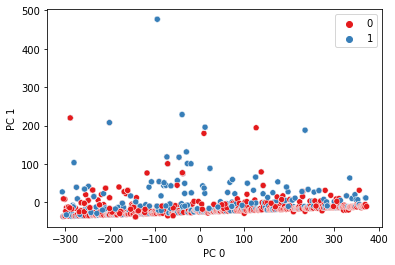

In [ ]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

Observando a escala dos atributos

In [ ]:
age_drop.groupby('Survived').mean().transpose()

Survived,0,1
Pclass,0.575472,0.993056
Sex,0.150943,0.677083
Age,30.626179,28.193299
SibSp,0.525943,0.496528
Parch,0.365566,0.531250
Ticket,243.266509,243.375000
Fare,22.965456,51.647672
Embarked,0.214623,0.329861


Verificando o peso dos componentes, fica claro que o ticket tem um peso bem diferente dos demais

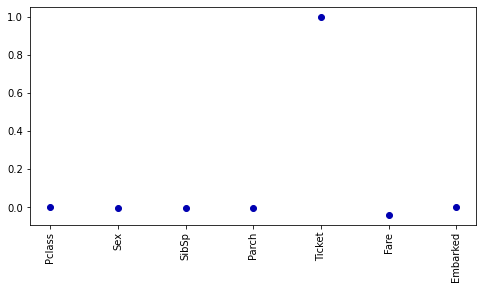

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(np.arange(len(X.columns)),pca.components_[0])
ax.set_xticks(np.arange(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=90)
plt.show()

In [ ]:
X

,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,0,0,1,0,0,7.2500,0
1,1,1,1,0,1,71.2833,1
2,0,1,0,0,2,7.9250,0
3,1,1,1,0,3,53.1000,0
4,0,0,0,0,4,8.0500,0
...,...,...,...,...,...,...,...
886,2,0,0,0,676,13.0000,0
887,1,1,0,0,677,30.0000,0
888,0,1,1,2,613,23.4500,0
889,1,0,0,0,678,30.0000,1


Normalizando o dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()  # instancia o StandardScaler
ss.fit(X)              # estima a média e o desvio-padrão de todos atributos
X_ss = ss.transform(X) # realiza a normalização z-score nos atributos

In [ ]:
#calcula o PCA com os atributos normalizados
pca_ss = PCA(n_components=2)
pca_ss.fit(X_ss)
X_ss_pca = pca_ss.transform(X_ss)
X_ss_pca_df = pd.DataFrame(X_ss_pca, columns=['PC 0', 'PC 1'])

Os pesos dos atributos em ambos componentes principais estão distribuídos. Isto nos dá a confiança que o PCA não está enviesado em nenhum atributo específico. Como estes componentes foram estimados com dados em mesma escala, sabemos que não há risco de enviesamento por conta de diferenças em escala.

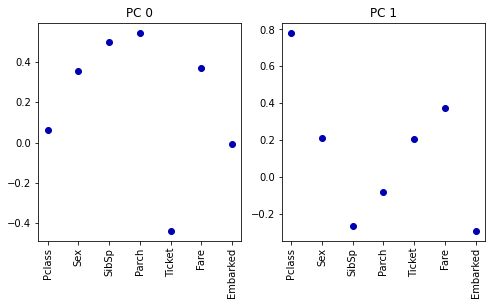

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
for idx, pc in enumerate(pca_ss.components_):
    ax[idx].scatter(np.arange(len(X.columns)), pc)
    ax[idx].set_xticks(np.arange(len(X.columns)))
    ax[idx].set_xticklabels(X.columns, rotation=90)
    ax[idx].set_title('PC %d' % (idx))
plt.show()

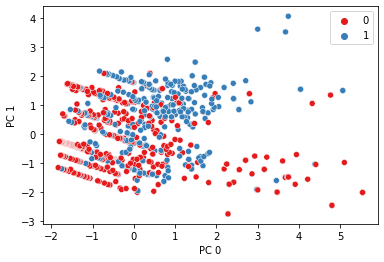

In [ ]:
sns.scatterplot(data=X_ss_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

Para verificar o quanto que a projeção do PCA representa os dados, decidi avaliar taxa de variância explicada pelos componentes principais usados na projeção.

In [ ]:
pca_ss.explained_variance_ratio_, sum(pca_ss.explained_variance_ratio_)

(array([0.27284336, 0.17492573]), 0.44776909034388057)

Os 2 primeiros componentes principais conseguem capturar 44% da variação dos dados. 

# Validação Cruzada

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
#a validação cruzada será realizada em 10 vias.
k_vias = 10
X = np.array(X)
#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X[idx_treino]
    y_treino = y[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X[idx_teste]
    y_teste = y[idx_teste]
    
    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #escolher o k com o melhor resultado no conjunto de validação e treinar o KNN com o melhor k.
    knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))

min: 0.74, max: 0.84, avg +- std: 0.79+-0.03


Esse resultado nos diz que podemos esperar que nosso classificador acerte entre 77% e 82% dos casos no mundo real

# KNN x SVM
## 1. KNN

Avaliando o desempenho do KNN nesta base de dados usando validação cruzada. 

In [ ]:
accs_knn = do_cv_knn(X, y, 10, range(1, 20, 2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
imprimir_estatisticas(accs_knn)

Resultados: 0.79 +- 0.03, min: 0.74, max: 0.84


## SVM

In [ ]:
accs_svm = do_cv_svm(X, y, 10, Cs=[1, 10, 100, 1000], gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4])

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
imprimir_estatisticas(accs_knn)

Resultados: 0.79 +- 0.03, min: 0.74, max: 0.84


In [ ]:
imprimir_estatisticas(accs_svm)

Resultados: 0.79 +- 0.04, min: 0.73, max: 0.84


A acurácia do SVM parece ter sido ligeiramente superior, porém o desvio padrão está razoavelmente alto.

# Teste de Hipótese Nula pelo Teste t de Student

In [ ]:
from scipy.stats import ttest_ind_from_stats

In [ ]:
#Primeiramente calculamos a média e o desvio padrão dos resultados
media_knn, std_knn, _, _ = calcular_estatisticas(accs_knn)
media_svm, std_svm, _, _ = calcular_estatisticas(accs_svm)

#calcular o pvalor usando o teste t de Student para duas amostras independentes
_, pvalor = ttest_ind_from_stats(media_knn, std_knn, len(accs_knn), media_svm, std_svm, len(accs_svm))

In [ ]:
pvalor

0.8309038350286067

In [ ]:
pvalor<=0.05

False

Como o valor é maior que 0.05, não é possível rejeitar a hipótese nula.
 Em outras palavras, não é possível afirmar que a SVM teve desempenho diferente do KNN nos testes que fizemos com esta base de dados.

In [ ]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [ ]:
rejeitar_hip_nula(media_knn, std_knn, len(accs_knn), media_svm, std_svm, len(accs_svm))

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
pred = knn.predict(X_test)
accuracy_score(y_test, pred)

0.6404494382022472

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


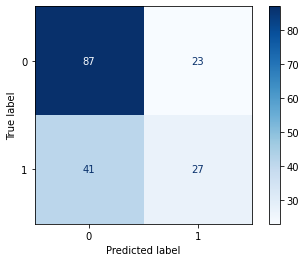

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues')

In [ ]:
precision_score(y_test,pred)

0.54

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([439, 272]))

In [ ]:
recall_score(y_test, pred)

0.39705882352941174

In [ ]:
f1_score(y_test, pred)

0.45762711864406785

# Train Dataset

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       110
           1       0.54      0.40      0.46        68

    accuracy                           0.64       178
   macro avg       0.61      0.59      0.59       178
weighted avg       0.63      0.64      0.63       178



# Age_drop Dataset

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70        85
           1       0.53      0.36      0.43        58

    accuracy                           0.61       143
   macro avg       0.58      0.57      0.57       143
weighted avg       0.59      0.61      0.59       143



# Conclusão

Ambos os conjuntos de dados apresentaram resultados bem próximos. Com pequenas variações entre os classificadores. Para ambos os casos, o SVM pareceu uma solução mais interessante.